# Upload NMF inputs and outputs to database
Charley Wu, November 2020

In [173]:
import pymongo
import os
import bson
import json
import glob
import pickle
import gridfs
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join as opj
from tqdm import notebook
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

Connect to database:

In [2]:
keyfile = 'credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['families', 'test', 'lifelogs', 'fs.files', 'jobmatrix', 'svd', 'fs.chunks']


## Jobmatrix

List job files:

In [32]:
job_col = db.jobmatrix #collection

n = job_col.estimated_document_count() #number of avatars
m = len(job_col.find_one()['items']) #number of items
jobMatrix = np.empty([n,m])

i = 0 #counter
for doc in job_col.find(): #iterate and build the job matrix
    jobMatrix[i,] = doc['items']
    i+=1

In [33]:
jobMatrix

array([[3., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Preprocessing

### Clean rows with too few interactions

(array([2.545e+03, 4.750e+02, 3.130e+02, 2.090e+02, 1.520e+02, 1.280e+02,
        9.000e+01, 6.400e+01, 3.600e+01, 2.400e+01, 1.600e+01, 9.000e+00,
        5.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.0540e+02, 2.0980e+02, 3.1420e+02, 4.1860e+02,
        5.2300e+02, 6.2740e+02, 7.3180e+02, 8.3620e+02, 9.4060e+02,
        1.0450e+03, 1.1494e+03, 1.2538e+03, 1.3582e+03, 1.4626e+03,
        1.5670e+03, 1.6714e+03, 1.7758e+03, 1.8802e+03, 1.9846e+03,
        2.0890e+03]),
 <a list of 20 Patch objects>)

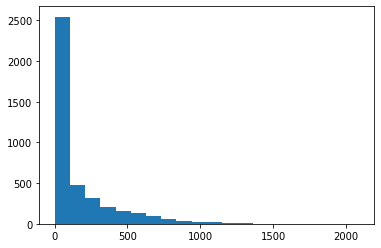

In [122]:
plt.hist(jobMatrix.sum(axis = 1), bins = 20) #histrogram of item iteractions

In [111]:
#Let's remove participants with the fewest item interactions using Tukey's outlier removal criterion
Q1 = np.quantile(jobMatrix.sum(axis = 1),0.25) #25th percentile is only! 1 item interaction
Q3 = np.quantile(jobMatrix.sum(axis = 1),0.75)
IQR = Q3- Q1 
lowerRange = Q1 - (1.5 * IQR)
lowerRange  #Nevermind, that's a negative number

-52.5

In [123]:
medianItems = np.quantile(jobMatrix.sum(axis = 1),0.50) 
#Median number of interactions is 39, let's use this for now as the cutoff
medianItems

39.0

In [124]:
jobMatrixCleaned = jobMatrix[jobMatrix.sum(axis = 1)>=medianItems ,] #trim all rows with fewer item interactions than the cutoff

### Clean empty columns 

(array([2.917e+03, 4.300e+01, 1.400e+01, 8.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([    0.  ,  1697.45,  3394.9 ,  5092.35,  6789.8 ,  8487.25,
        10184.7 , 11882.15, 13579.6 , 15277.05, 16974.5 , 18671.95,
        20369.4 , 22066.85, 23764.3 , 25461.75, 27159.2 , 28856.65,
        30554.1 , 32251.55, 33949.  ]),
 <a list of 20 Patch objects>)

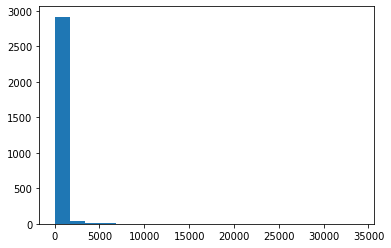

In [125]:
plt.hist(jobMatrixCleaned.sum(axis = 0), bins = 20) #histrogram of items and how many different players interact with them

In [131]:
jobMatrixCleaned = jobMatrixCleaned[:,jobMatrixCleaned.sum(axis = 0)>0] #remove all columns that no users have interacted with

In [133]:
jobMatrixCleaned.shape #new cleaned job matrix dimensions
#TODO: Build a dictionary to relate each row to each avatar id and each player id; relate each column to an item id 

(2043, 1502)

### TF-IDF normalization

In [134]:
#Term frequency: let's use augmented frequency, which prevents a bias towards longer documents (i.e., players who have many item interactions)
def tf(avatarVec):
    return(0.5 + ((0.5* avatarVec) / max(avatarVec)))

#inverse document frequency:
def idf(itemVec):
    return(np.log(sum(itemVec)/len(itemVec[itemVec>0])))

In [135]:
#compute tf and idf mats
tfMat = np.ones(jobMatrixCleaned.shape)
for row in range(jobMatrixCleaned.shape[0]):
    tfMat[row,:] = tf(jobMatrixCleaned[row,:]) 
idfMat = np.ones(jobMatrixCleaned.shape)
for col in range(jobMatrixCleaned.shape[1]):
    idfMat[:,col] = idf(jobMatrixCleaned[:,col]) 
tfIdfMat = tfMat * idfMat

In [137]:
tfidfJobMatrix = tfIdfMat * jobMatrixCleaned #now compute tfidf

In [141]:
#Normalized rows
row_sums = tfidfJobMatrix.sum(axis=1)
tfidfJobMatrixNormalized = tfidfJobMatrix / row_sums[:, np.newaxis]

# Non-negative matrix factorization

In [142]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(tfidfJobMatrixNormalized)
H = model.components_
#TODO: Save W and H matrices somewhere

## Interpreting the components

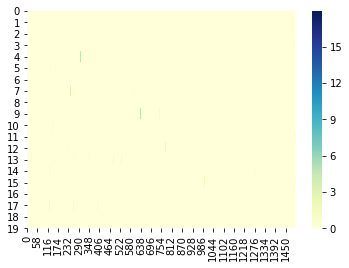

In [147]:
ax = sns.heatmap(H,  cmap="YlGnBu") #x-axis are unique items and y-axis are the loadings

(array([8., 7., 2., 2., 0., 0., 0., 0., 0., 1.]),
 array([ 1.03032134,  5.16520429,  9.30008725, 13.4349702 , 17.56985315,
        21.7047361 , 25.83961905, 29.97450201, 34.10938496, 38.24426791,
        42.37915086]),
 <a list of 10 Patch objects>)

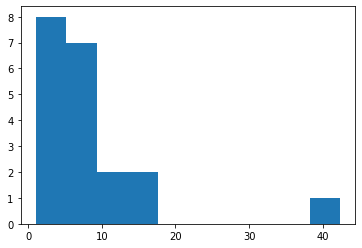

In [183]:
#What is the distribution of total loadings across items?
plt.hist(H.sum(axis = 1))

In [152]:
#Which items most strongly defined each component?
np.argmax(H, 1) #TODO build dictionary method to interpret

array([ 161,  249,  199,  811,  303,   13,    0,  247,  145,  639,  865,
       1287,  779,    4,  255,  998,  209,  641, 1409, 1459])

## Interpreting avatar embeddings

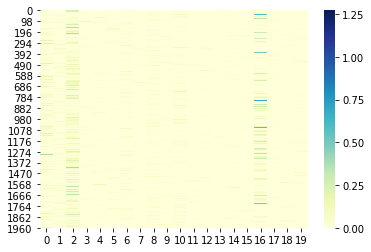

In [153]:
ax = sns.heatmap(W,  cmap="YlGnBu") #players are loading very heavily onto dims 2 and 16. We may need better preprocessing

(array([ 537., 1025.,  339.,   79.,   28.,   19.,    6.,    3.,    4.,
           3.]),
 array([0.03914325, 0.16310313, 0.287063  , 0.41102288, 0.53498276,
        0.65894263, 0.78290251, 0.90686238, 1.03082226, 1.15478214,
        1.27874201]),
 <a list of 10 Patch objects>)

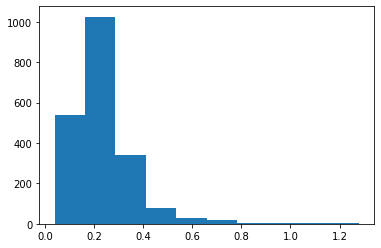

In [155]:
#Sum of loadings 
plt.hist(W.sum(axis = 1)) #The magnitude of the embedding vector for each player tells us how confidently we are able to assign that player to the latent space. 

In [156]:
#TODO: filter avatars with low magnitude in W

In [166]:
#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(W)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [167]:
print(pca.explained_variance_) #not very much

[0.01733565 0.00577194]


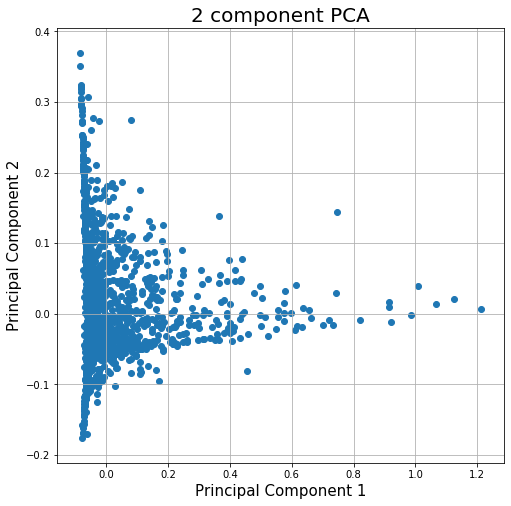

In [172]:
#Job space embeddings
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'])
ax.grid()